In [17]:
from path import setup_project_root

setup_project_root()

In [18]:
import glob 

base = '/om2/user/moshepol/prosody/models/sr=16000n_fft=2048hop_length=256'

inputs = glob.glob(f'{base}/inputs*.pt')
labels = glob.glob(f'{base}/outputs*.pt')

In [19]:
print(f'Total Inputs: {len(inputs)}')
print(f'Total Outputs: {len(labels)}')

Total Inputs: 10
Total Outputs: 10


In [20]:
import torch
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

tensors = []
first = {'train' : {'en' : ''}}

for i, (inp, out) in enumerate(zip(inputs, labels)):

    if i % 5 == 0:
        print(inp.split('/')[-1])
        print(out.split('/')[-1])

    if i == 0:
        first['train']['en'] = torch.load(inp, weights_only=False)

    tensors.append(
        TensorDataset(
            torch.load(inp, weights_only=False), 
            torch.load(out, weights_only=False)
            )
        )

inputs_0.pt
outputs_0.pt
inputs_5.pt
outputs_5.pt


In [21]:
data = ConcatDataset(tensors)
loader = DataLoader(data, batch_size=256, num_workers=4, shuffle=False)

In [22]:
first['train']['en'][0].shape

torch.Size([1025, 344])

In [23]:
import joblib

encoder = joblib.load(f'{base}label_encoder.pkl')

class_to_index = {label : idx for idx, label in enumerate(encoder.classes_)}

print(class_to_index)

{np.str_('de'): 0, np.str_('en'): 1, np.str_('es'): 2, np.str_('it'): 3}


In [24]:
from Multi_Lang_GPU import LanguageDetector

num_classes = 4

model = LanguageDetector(num_classes, first['train']['en'][0].shape)

model.load_state_dict(torch.load(f'{base}/best_model.pth', weights_only=True))
model.eval()

model.to('cuda')

LanguageDetector(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=704512, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [25]:
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, label in loader:

        inputs = inputs.to('cuda')
        label = label.to('cuda')

        inputs = inputs.unsqueeze(1)

        outputs = model(inputs)

        _, predicted = torch.max(outputs, dim=1)

        y_pred.append(predicted)
        y_true.append(label)

In [26]:
y_pred = torch.cat(y_pred).cpu()
y_true = torch.cat(y_true).cpu()

In [38]:
name = base.split('/')[-1]

In [40]:
from sklearn.metrics import accuracy_score

acc = f"Accuracy: {accuracy_score(y_true, y_pred)}"

print(acc)

with open(f'review/{name}.txt', 'w') as f:
    f.write(acc)

Accuracy: 0.48828125


In [44]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=encoder.classes_, output_dict=True)

print("\nClassification Report:\n", report)

df = pd.DataFrame(report)

df.to_csv(f'review/{name}')


Classification Report:
 {np.str_('de'): {'precision': 0.4969604863221885, 'recall': 0.5109375, 'f1-score': 0.5038520801232665, 'support': 640.0}, np.str_('en'): {'precision': 0.6016949152542372, 'recall': 0.44375, 'f1-score': 0.5107913669064749, 'support': 640.0}, np.str_('es'): {'precision': 0.44244105409153955, 'recall': 0.4984375, 'f1-score': 0.46877296105804556, 'support': 640.0}, np.str_('it'): {'precision': 0.4513399153737659, 'recall': 0.5, 'f1-score': 0.4744255003706449, 'support': 640.0}, 'accuracy': 0.48828125, 'macro avg': {'precision': 0.4981090927604328, 'recall': 0.48828125, 'f1-score': 0.48946047711460794, 'support': 2560.0}, 'weighted avg': {'precision': 0.49810909276043275, 'recall': 0.48828125, 'f1-score': 0.48946047711460794, 'support': 2560.0}}


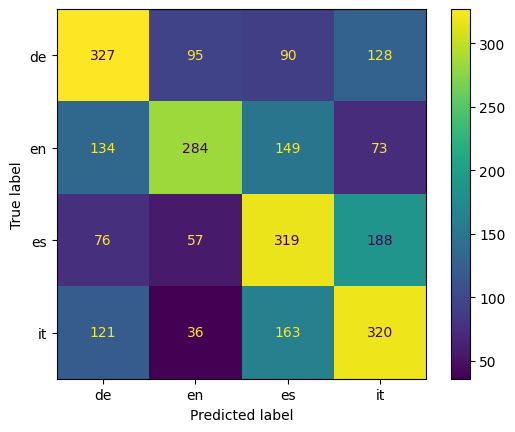

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(xticks_rotation='horizontal')
plt.savefig(f'review/{name}.png')